In [38]:
pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [136]:
pip install colour

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import pandasql as ps
from colour import Color

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [40]:
df = pd.read_excel('/content/drive/MyDrive/dataset/ecommerce/Online Retail.xlsx')

In [41]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
521087,580311,22588,CARD HOLDER GINGHAM HEART,6,2011-12-02 14:48:00,2.89,18245.0,United Kingdom
416220,572552,22277,COSMETIC BAG VINTAGE ROSE PAISLEY,1,2011-10-24 17:07:00,4.13,14096.0,United Kingdom
141018,548496,22900,SET 2 TEA TOWELS I LOVE LONDON,72,2011-03-31 13:40:00,3.25,12678.0,France
24393,538349,21428,SET3 BOOK BOX GREEN GINGHAM FLOWER,1,2010-12-10 14:59:00,8.47,NaN,United Kingdom
229528,557063,72802C,VANILLA SCENT CANDLE JEWELLED BOX,4,2011-06-16 15:01:00,4.25,17368.0,United Kingdom


## Data Understanding

In [42]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Top 20 Product

In [43]:
top20 = df.groupby('Description')['Quantity'].sum().reset_index().sort_values('Quantity', ascending=False).head(20)
fig = px.bar(top20, x='Description', y='Quantity')
fig.show()

#### Top 20 Canceled Product

In [44]:
top20_c = df.groupby('Description', as_index=False)['Quantity']\
            .apply(lambda x: x[x<0].sum())\
            .sort_values('Quantity', ascending=True).head(20)
fig = px.bar(top20_c, x='Description', y='Quantity')
fig.show()

### Country

In [45]:
country = df['Country'].value_counts().reset_index().sort_values('Country', ascending=False)
fig = px.bar(country, x='index', y='Country')
fig.update_xaxes(tickangle=-90)
fig.show()

#### Without UK

In [46]:
country = df['Country'].value_counts().reset_index()[1:].sort_values('Country', ascending=False)
fig = px.bar(country, x='index', y='Country')
fig.update_xaxes(tickangle=-90)
fig.show()

### Invoice Date

In [47]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [48]:
df['Day'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour
df['Month'] = df['InvoiceDate'].dt.month

#### Day

In [49]:
day = df['Day'].value_counts().reset_index().sort_values('index', ascending=False)
fig = px.bar(day, x='index', y='Day')
fig.show()

#### Hour

In [50]:
hour = df['Hour'].value_counts().reset_index().sort_values('index', ascending=False)
fig = px.bar(hour, x='index', y='Hour')
fig.show()

In [51]:
day_hour = df.groupby(['Day','Hour'])['InvoiceNo'].count().unstack().fillna(0)
fig = px.imshow(day_hour, x=day_hour.columns, y=day_hour.index)
fig.show()

## Data Preparation

#### Remove missing value

In [52]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Day                 0
Hour                0
Month               0
dtype: int64

In [53]:
df = df.dropna(subset='CustomerID')

#### Add total price

In [54]:
df['TotalPrice'] = df['UnitPrice']*df['Quantity']

<ipython-input-54-09f5c04b7015>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## RFM Features

In [55]:
#Recency
max_date = df['InvoiceDate'].dt.date.max()
r = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
r['InvoiceDate'] = r['InvoiceDate'].dt.date
r['recency'] = r['InvoiceDate'].apply(lambda x: (max_date-x).days)
r = r.drop('InvoiceDate', axis=1)

In [56]:
#Frequency
f = df.groupby('CustomerID', as_index=False)['InvoiceDate'].nunique()
f.columns = ['CustomerID','frequency']

In [57]:
#Monetary
m = df.groupby('CustomerID', as_index=False)['TotalPrice'].sum()
m.columns = ['CustomerID','monetary']

In [58]:
rfm = r.merge(f, on='CustomerID', how='left')
rfm = rfm.merge(m, on='CustomerID', how='left')

### Other

In [83]:
def dataset():
  q='''
    SELECT CustomerID,
            COUNT(DISTINCT StockCode),
            AVG(Quantity),
            AVG(UnitPrice)
    FROM df
    GROUP BY 1
    '''
  return q

dataset = ps.sqldf(dataset())
dataset.head(3)

,CustomerID,COUNT(DISTINCT StockCode),AVG(Quantity),AVG(UnitPrice)
0,12346.0,1,0.000000,1.040000
1,12347.0,103,13.505495,2.644011
2,12348.0,22,75.516129,5.764839


In [60]:
dataset = dataset.merge(rfm, on='CustomerID', how='inner')
dataset.head(3)

,CustomerID,COUNT(DISTINCT StockCode),AVG(Quantity),AVG(UnitPrice),recency,frequency,monetary
0,12346.0,1,0.000000,1.040000,325,2,0.00
1,12347.0,103,13.505495,2.644011,2,7,4310.00
2,12348.0,22,75.516129,5.764839,75,4,1797.24


## Modeling and Evaluation

### Scaling

In [61]:
rfm = rfm.drop('CustomerID', axis=1)
cols = rfm.columns.tolist()
rfm_scaled = StandardScaler().fit_transform(rfm)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=cols)
rfm_scaled.head()

,recency,frequency,monetary
0,2.316568,-0.328714,-0.231001
1,-0.889050,0.211970,0.293432
2,-0.164560,-0.112440,-0.012316
3,-0.730258,-0.436851,-0.017146
4,2.167700,-0.436851,-0.190312


### Best K

In [68]:
sil = []
for i in range(3,15):
    kmeans = KMeans(n_clusters=i, n_init='auto').fit(rfm_scaled)
    preds = kmeans.predict(rfm_scaled)
    euclidean = silhouette_score(rfm_scaled, preds, metric='euclidean')
    print('n_clusters:', i,'. Silhouette score:', euclidean)
    sil.append(euclidean)

n_clusters: 3 . Silhouette score: 0.5872556881311201
n_clusters: 4 . Silhouette score: 0.610646796092451
n_clusters: 5 . Silhouette score: 0.601794062525489
n_clusters: 6 . Silhouette score: 0.5926621712341616
n_clusters: 7 . Silhouette score: 0.49854699169271244
n_clusters: 8 . Silhouette score: 0.5161510617274915
n_clusters: 9 . Silhouette score: 0.40194754839059155
n_clusters: 10 . Silhouette score: 0.490412742552938
n_clusters: 11 . Silhouette score: 0.4000747614199164
n_clusters: 12 . Silhouette score: 0.40848391430219366
n_clusters: 13 . Silhouette score: 0.3988279838906316
n_clusters: 14 . Silhouette score: 0.40494310238114267


In [69]:
fig = px.line(x=range(3,15), y=sil, markers=True)
fig.show()

### Clustering

In [72]:
kmeans = KMeans(n_clusters=4, n_init=10, random_state=100)
kmeans.fit(rfm_scaled)

KMeans(n_clusters=4, n_init=10, random_state=100)

In [85]:
rfm['cluster'] = kmeans.labels_
rfm['aov'] = rfm['monetary']/rfm['frequency']
dataset['cluster'] = kmeans.labels_

In [74]:
perc = np.arange(0.1,1,0.1)
rfm.describe(percentiles=perc)

,recency,frequency,monetary,cluster,aov
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,91.581199,5.039799,1898.459701,1.227356,317.302387
std,100.772139,9.248607,8219.345141,0.476395,365.792196
min,0.000000,1.000000,-4287.630000,0.000000,-4287.630000
10%,4.000000,1.000000,146.022000,1.000000,100.126583
20%,11.000000,1.000000,234.392000,1.000000,138.038667
30%,21.000000,1.000000,337.370000,1.000000,167.349875
40%,31.000000,2.000000,465.412000,1.000000,200.131429
50%,50.000000,3.000000,648.075000,1.000000,237.475937
60%,71.000000,4.000000,909.134000,1.000000,288.806857


## Clustering Analysis

In [75]:
rfm_summary = rfm.groupby('cluster').agg({'recency':'mean',
                                          'frequency':'mean',
                                          'monetary':['mean','median'],
                                          'aov':'mean'})
rfm_summary

recency  frequency       monetary                      aov
               mean       mean           mean      median         mean
cluster                                                               
0          8.773585  40.547170   18940.097736   12091.895   554.108695
1         41.066520   4.808008    1483.679591     856.680   323.898986
2        247.386949   1.799632     453.209468     296.815   259.501435
3          7.166667  87.833333  182181.981667  160027.395  3127.561923

0 : potential loyal customer <br>
1 : new customer <br>
2 : lost customer <br>
3 : champion <br>

### Cluster Distribution

In [86]:
cluster_summary = dataset.groupby('cluster', as_index=False)['CustomerID'].count()
cluster_summary.columns = ['cluster','count']
cluster_summary

,cluster,count
0,0,106
1,1,3172
2,2,1088
3,3,6


In [78]:
fig = px.bar(cluster_summary, x='cluster', y='count')
fig.show()

0 : potential loyal customer <br>
1 : new customer <br>
2 : lost customer <br>
3 : champion <br>
From the graph, it can be concluded that this e-commerce need more loyal customers and champion customers.

In [87]:
df_cluster = df.merge(dataset, on='CustomerID', how='left')
df_cluster.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Hour,Month,TotalPrice,COUNT(DISTINCT StockCode),AVG(Quantity),AVG(UnitPrice),cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2,8,12,15.30,24,5.426282,3.924712,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,8,12,20.34,24,5.426282,3.924712,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2,8,12,22.00,24,5.426282,3.924712,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,8,12,20.34,24,5.426282,3.924712,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,8,12,20.34,24,5.426282,3.924712,0


### End Customer - Country

In [89]:
def data():
  q='''
    SELECT cluster,
            Country,
            COUNT(DISTINCT CustomerID) AS total_customer
    FROM df_cluster
    GROUP BY 1,2
    ORDER BY 1,3 DESC
    '''
  return q

cls_country = ps.sqldf(data())
cls_country.head()

,cluster,Country,total_customer
0,0,United Kingdom,97
1,0,Germany,6
2,0,France,2
3,0,Sweden,1
4,1,United Kingdom,2866


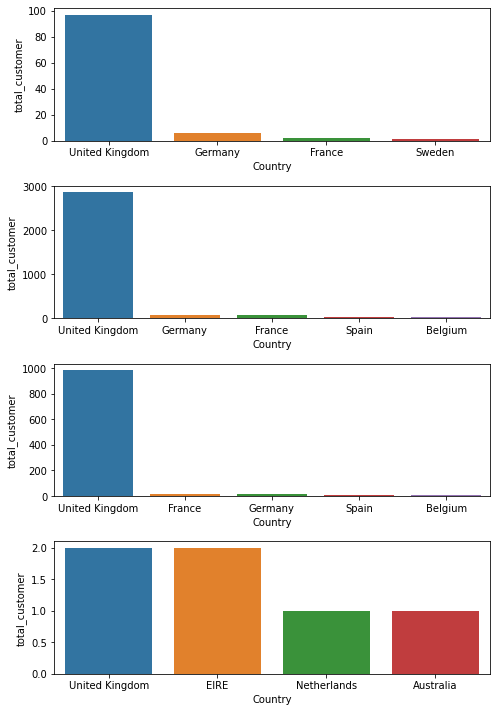

In [181]:
fig, ax = plt.subplots(4,1,figsize=(7,10))
for i in range(0,4):
  sns.barplot(data=cls_country[cls_country['cluster']==i][:5],
              x='Country', y='total_customer', ax=ax[i])
plt.tight_layout()

### End Customer - Product

In [110]:
def data():
  q='''
    SELECT cluster,
            StockCode,
            Description,
            COUNT(DISTINCT CustomerID) AS total_customer
    FROM df_cluster
    GROUP BY 1,2
    ORDER BY 1,4 DESC
    '''
  return q

cls_product = ps.sqldf(data())
cls_product.head()

,cluster,StockCode,Description,total_customer
0,0,22423,REGENCY CAKESTAND 3 TIER,64
1,0,21212,PACK OF 72 RETROSPOT CAKE CASES,60
2,0,85099B,JUMBO BAG RED RETROSPOT,56
3,0,47566,PARTY BUNTING,48
4,0,23245,SET OF 3 REGENCY CAKE TINS,48


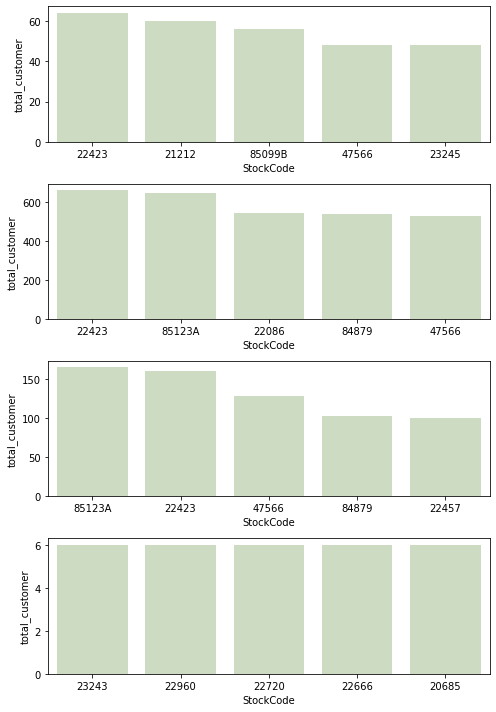

In [179]:
fig, ax = plt.subplots(4,1,figsize=(7,10))
for i in range(0,4):
  sns.barplot(data=cls_product[cls_product['cluster']==i][:5],
              x='StockCode', y='total_customer', ax=ax[i], color='#cbdfbd')
plt.tight_layout()

### End Customer - Quantity

In [128]:
def data():
  q='''
    SELECT cluster,
            Quantity,
            COUNT(DISTINCT CustomerID) AS total_customer
    FROM df_cluster
    GROUP BY 1,2
    ORDER BY 1,3 DESC
    '''
  return q

cls_qty = ps.sqldf(data())
cls_qty.head()

,cluster,Quantity,total_customer
0,0,12,99
1,0,24,98
2,0,6,98
3,0,48,94
4,0,10,94


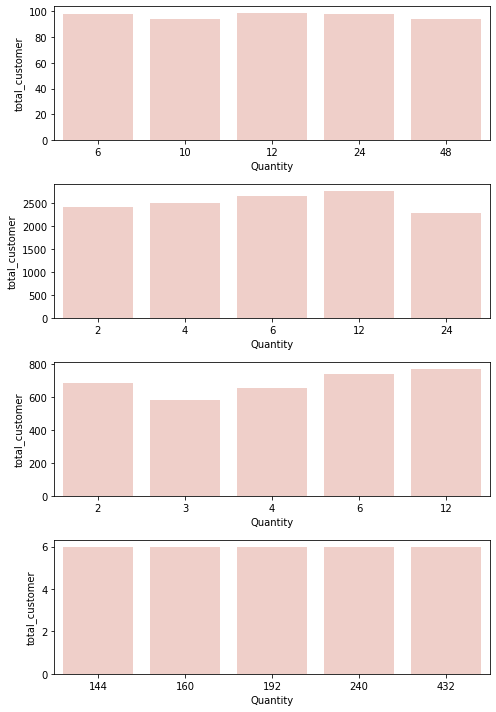

In [176]:
fig, ax = plt.subplots(4,1,figsize=(7,10))
for i in range(0,4):
  sns.barplot(data=cls_qty[cls_qty['cluster']==i][:5],
              x='Quantity', y='total_customer',ax=ax[i], color='#f5cac3')
plt.tight_layout()